In [6]:
import gymnasium as gym
import gymnasium_robotics
import time

gym.register_envs(gymnasium_robotics)

env = gym.make('PointMaze_UMaze-v3')
obs, info = env.reset()

In [7]:
import numpy as np

#Acciones discretizadas en eje x e y
acciones_discretas = {
    0: np.array([ 1.0,  0.0]),  #derecha
    1: np.array([-1.0,  0.0]),  #izquierda
    2: np.array([ 0.0,  1.0]),  #arriba
    3: np.array([ 0.0, -1.0]),  #abajo
    4: np.array([ 0.0,  0.0]),  #sin moverse
}

In [8]:
import time
import gymnasium as gym
import gymnasium_robotics

gym.register_envs(gymnasium_robotics)

# Probar cada acciones
for i in acciones_discretas:
    print(f"Probando accion {i}")
    
    env = gym.make('PointMaze_UMaze-v3', render_mode="human")
    obs, info = env.reset()

    for _ in range(50):
        action_array = acciones_discretas[i].astype(np.float32)
        obs, reward, terminated, truncated, _ = env.step(action_array)
        env.render()
        time.sleep(0.05)
        if terminated or truncated:
            break

    env.close()


Probando accion 0
Probando accion 1
Probando accion 2
Probando accion 3
Probando accion 4



Valores de mejor_Q:
Accion 0: Q = 0.6213
Accion 1: Q = 0.8557
Accion 2: Q = 0.9814
Accion 3: Q = 0.6213
Accion 4: Q = 0.6633


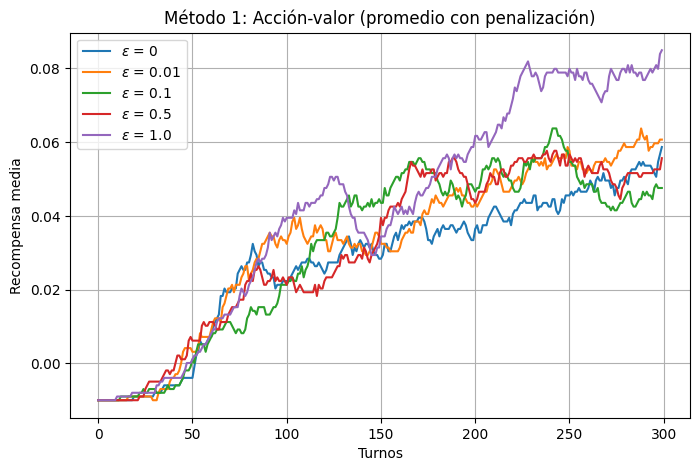

In [ ]:
# Metodo 1: Accion-valor
import matplotlib.pyplot as plt
import numpy as np
import random

# Semillas
np.random.seed(32)
random.seed(32)

# Parametros
partidas = 1000
turnos = 300
epsilons = [0, 0.01, 0.1, 0.5, 1.0]
recompensas_medias = np.zeros((len(epsilons), turnos))

mejor_Q = None
mejor_recompensa_total = -1

for ep in range(partidas):
    for i, epsilon in enumerate(epsilons):
        Q = {a: 0 for a in acciones_discretas}
        N = {a: 0 for a in acciones_discretas}
        obs, info = env.reset()
        recompensa_total = 0

        for t in range(turnos):
            # Elegir accion
            if np.random.rand() < epsilon:
                accion = np.random.choice(list(acciones_discretas.keys()))
            else:
                max_valor = max(Q.values())
                mejores = [a for a in Q if Q[a] == max_valor]
                accion = np.random.choice(mejores)

            # Ejecutar accion
            obs, reward, terminated, truncated, _ = env.step(acciones_discretas[accion])
            done = terminated or truncated

            # Recompensa
            distancia = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
            recompensa = 1.0 if distancia < 0.5 else -0.01 # Penalizacion

            # Actualizar el promedio incremental
            N[accion] += 1
            Q[accion] += (recompensa - Q[accion]) / N[accion]

            recompensa_total += recompensa
            recompensas_medias[i][t] += recompensa

            if done:
                break

        # Guardar mejor Q
        if recompensa_total > mejor_recompensa_total:
            mejor_recompensa_total = recompensa_total
            mejor_Q = Q.copy()

# Promediar recompensas
recompensas_medias /= partidas

print("\nValores de mejor_Q:")
for k, v in mejor_Q.items():
    print(f"Accion {k}: Q = {v:.4f}")

plt.figure(figsize=(8,5))
for i, epsilon in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f"$\\epsilon$ = {epsilon}")
plt.xlabel("Turnos")
plt.ylabel("Recompensa media")
plt.title("Método 1: Acción-valor (promedio con penalización)")
plt.grid(True)
plt.legend()
plt.show()



Valores de mejor_Q:
Accion 0: Q = 0.9912
Accion 1: Q = 0.9984
Accion 2: Q = 0.9835
Accion 3: Q = 0.9912
Accion 4: Q = 0.9912


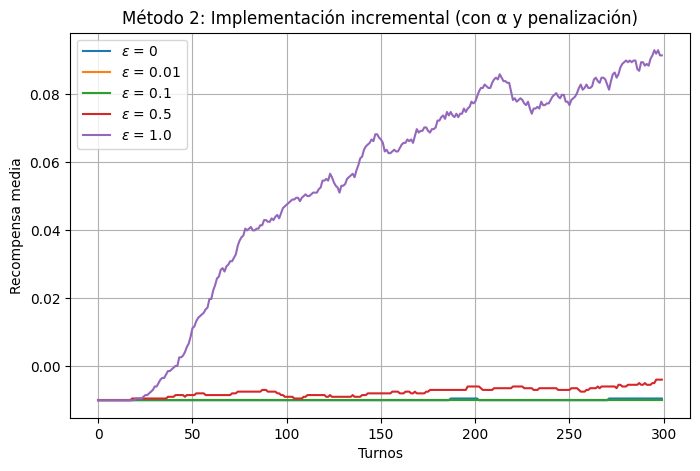

In [ ]:
# Metodo 2: Implementacion incremental

np.random.seed(32)
random.seed(32)

partidas = 2000
turnos = 300
alpha = 0.1
epsilons = [0, 0.01, 0.1, 0.5, 1.0]
recompensas_medias = np.zeros((len(epsilons), turnos))

mejor_Q = None
mejor_recompensa_total = -1

for ep in range(partidas):
    for i, epsilon in enumerate(epsilons):
        Q = {a: 0 for a in acciones_discretas}
        obs, info = env.reset()
        recompensa_total = 0

        for t in range(turnos):
            # Elegir accion
            if np.random.rand() < epsilon:
                accion = np.random.choice(list(acciones_discretas.keys()))
            else:
                max_valor = max(Q.values())
                mejores = [a for a in Q if Q[a] == max_valor]
                accion = np.random.choice(mejores)

            # Ejecutar accion
            obs, reward, terminated, truncated, _ = env.step(acciones_discretas[accion])
            done = terminated or truncated

            # Recompensa
            distancia = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
            recompensa = 1.0 if distancia < 0.5 else -0.01

            # Actualizacion incremental (con α)
            Q[accion] += alpha * (recompensa - Q[accion])

            recompensa_total += recompensa
            recompensas_medias[i][t] += recompensa

            if done:
                break

        # Guardar el mejor Q
        if recompensa_total > mejor_recompensa_total:
            mejor_recompensa_total = recompensa_total
            mejor_Q = Q.copy()

recompensas_medias /= partidas

print("\nValores de mejor_Q:")
for k, v in mejor_Q.items():
    print(f"Accion {k}: Q = {v:.4f}")

plt.figure(figsize=(8,5))
for i, epsilon in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f"$\\epsilon$ = {epsilon}")
plt.xlabel("Turnos")
plt.ylabel("Recompensa media")
plt.title("Método 2: Implementación incremental (con α y penalización)")
plt.grid(True)
plt.legend()
plt.show()



Valores de mejor_Q:
Accion 0: Q = 11.3960
Accion 1: Q = 11.3960
Accion 2: Q = 11.3960
Accion 3: Q = 11.3960
Accion 4: Q = 11.3960


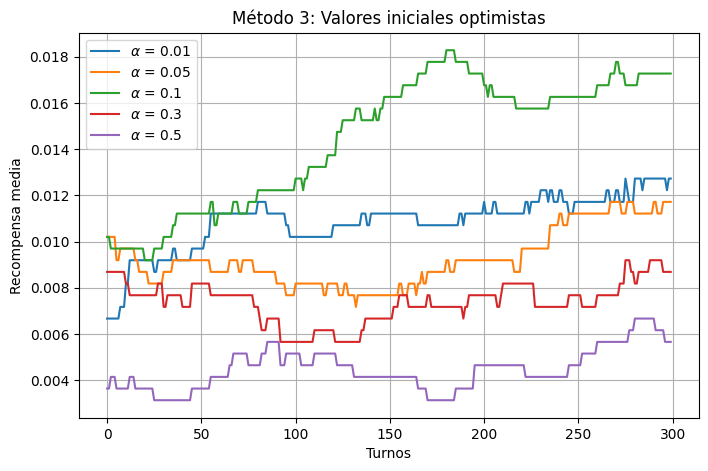

In [18]:
# Metodo 3: Valores iniciales optimistas
np.random.seed(32)
random.seed(32)

partidas = 2000
turnos = 300
Q_inicial = 20.0
alphas = [0.01, 0.05, 0.1, 0.3, 0.5]
recompensas_medias = np.zeros((len(alphas), turnos))

mejor_Q = None
mejor_recompensa_total = -1

for ep in range(partidas):
    for i, alpha in enumerate(alphas):
        Q = {a: Q_inicial for a in acciones_discretas}
        obs, info = env.reset()
        recompensa_total = 0

        for t in range(turnos):
            # Seleccion accion pura
            accion = max(Q, key=Q.get)

            # Ejecutar accion
            obs, reward, terminated, truncated, _ = env.step(acciones_discretas[accion])
            done = terminated or truncated

            # Recompensa con penalizacion
            distancia = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
            recompensa = 1.0 if distancia < 0.7 else -0.01

            # Actualizacion
            Q[accion] += alpha * (recompensa - Q[accion])
            recompensa_total += recompensa
            recompensas_medias[i][t] += recompensa

            if done:
                break

        if recompensa_total > mejor_recompensa_total:
            mejor_recompensa_total = recompensa_total
            mejor_Q = Q.copy()

recompensas_medias /= partidas

print("\nValores de mejor_Q:")
for k, v in mejor_Q.items():
    print(f"Accion {k}: Q = {v:.4f}")

plt.figure(figsize=(8,5))
for i, alpha in enumerate(alphas):
    plt.plot(recompensas_medias[i], label=f"$\\alpha$ = {alpha}")
plt.xlabel("Turnos")
plt.ylabel("Recompensa media")
plt.title("Método 3: Valores iniciales optimistas")
plt.grid(True)
plt.legend()
plt.show()


Ep 0, t 1, acción 3, distancia: 1.067, recompensa: -0.01
Ep 0, t 2, acción 1, distancia: 1.070, recompensa: -0.01
Ep 0, t 3, acción 4, distancia: 1.073, recompensa: -0.01
Ep 0, t 4, acción 0, distancia: 1.073, recompensa: -0.01
Ep 0, t 1, acción 0, distancia: 2.223, recompensa: -0.01
Ep 0, t 2, acción 2, distancia: 2.226, recompensa: -0.01
Ep 0, t 3, acción 1, distancia: 2.226, recompensa: -0.01
Ep 0, t 4, acción 3, distancia: 2.225, recompensa: -0.01
Ep 0, t 1, acción 2, distancia: 0.918, recompensa: -0.01
Ep 0, t 2, acción 4, distancia: 0.915, recompensa: -0.01
Ep 0, t 3, acción 3, distancia: 0.915, recompensa: -0.01
Ep 0, t 4, acción 0, distancia: 0.915, recompensa: -0.01
Ep 0, t 1, acción 4, distancia: 0.982, recompensa: -0.01
Ep 0, t 2, acción 1, distancia: 0.982, recompensa: -0.01
Ep 0, t 3, acción 3, distancia: 0.980, recompensa: -0.01
Ep 0, t 4, acción 2, distancia: 0.980, recompensa: -0.01
Ep 0, t 1, acción 4, distancia: 2.352, recompensa: -0.01
Ep 0, t 2, acción 0, distancia:

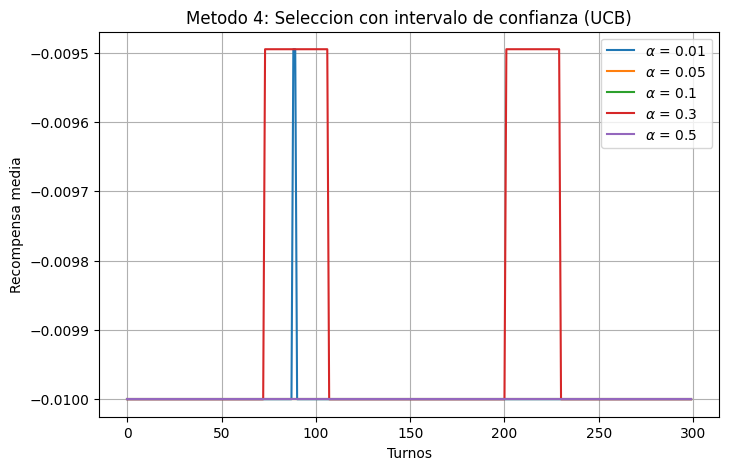

In [ ]:
# Metodo 4: Accion con intervalo de confianza
np.random.seed(32)
random.seed(32)

partidas = 2000
turnos = 300
c = 4
alphas = [0.01, 0.05, 0.1, 0.3, 0.5]
recompensas_medias = np.zeros((len(alphas), turnos))

mejor_Q = None
mejor_recompensa_total = -1

for ep in range(partidas):
    for i, alpha in enumerate(alphas):
        Q = {a: 10.0 for a in acciones_discretas}     # Inicializacion optimista
        N = {a: 1e-5 for a in acciones_discretas}     # Evitar division por cero
        obs, info = env.reset()
        recompensa_total = 0

        for t in range(1, turnos + 1):
            # Seleccion de accion con UCB
            ucb_values = {
                a: Q[a] + c * np.sqrt(np.log(t) / N[a])
                for a in acciones_discretas
            }
            max_valor = max(ucb_values.values())
            mejores = [a for a in ucb_values if ucb_values[a] == max_valor]
            accion = np.random.choice(mejores)

            # Ejecutar accion
            obs, reward, terminated, truncated, _ = env.step(acciones_discretas[accion])
            done = terminated or truncated

            # Recompensa
            distancia = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
            recompensa = 1.0 if distancia < 0.5 else -0.01

            # Debug
            if ep == 0 and t < 5:
                print(f"Ep {ep}, t {t}, acción {accion}, distancia: {distancia:.3f}, recompensa: {recompensa}")

            # Actualizacion
            Q[accion] += alpha * (recompensa - Q[accion])
            N[accion] += 1

            recompensa_total += recompensa
            recompensas_medias[i][t - 1] += recompensa

            if done:
                break

        if recompensa_total > mejor_recompensa_total:
            mejor_recompensa_total = recompensa_total
            mejor_Q = Q.copy()

recompensas_medias /= partidas

print("\nValores de mejor_Q:")
for k, v in mejor_Q.items():
    print(f"Accion {k}: Q = {v:.4f}")

plt.figure(figsize=(8,5))
for i, alpha in enumerate(alphas):
    plt.plot(recompensas_medias[i], label=f"$\\alpha$ = {alpha}")
plt.xlabel("Turnos")
plt.ylabel("Recompensa media")
plt.title("Metodo 4: Seleccion con intervalo de confianza (UCB)")
plt.grid(True)
plt.legend()
plt.show()



Valores de mejor_H (preferencias):
Acción 0: H = 0.0424
Acción 1: H = -0.0163
Acción 2: H = 0.0311
Acción 3: H = -0.0160
Acción 4: H = -0.0412


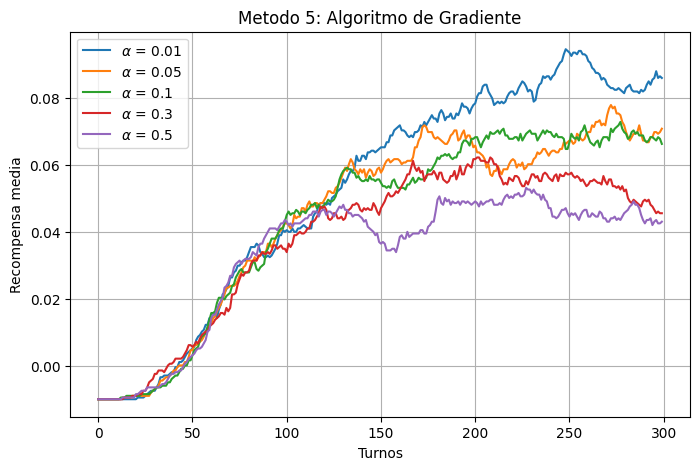

In [20]:
# Metodo 5: Algoritmo de Gradiente
np.random.seed(32)
random.seed(32)

partidas = 2000
turnos = 300
alphas = [0.01, 0.05, 0.1, 0.3, 0.5]
recompensas_medias = np.zeros((len(alphas), turnos))

mejor_H = None
mejor_recompensa_total = -1

for ep in range(partidas):
    for i, alpha in enumerate(alphas):
        H = {a: 0.0 for a in acciones_discretas}  # preferencias
        promedio_recompensas = 0
        obs, info = env.reset()
        recompensa_total = 0

        for t in range(turnos):
            # Softmax de preferencias
            exp_H = np.exp([H[a] for a in acciones_discretas])
            sum_exp_H = np.sum(exp_H)
            pi = {a: exp_H[i] / sum_exp_H for i, a in enumerate(acciones_discretas)}

            # Selección de accion por probabilidad
            acciones = list(acciones_discretas.keys())
            probabilidades = [pi[a] for a in acciones]
            accion = np.random.choice(acciones, p=probabilidades)

            # Ejecutar accion
            obs, reward, terminated, truncated, _ = env.step(acciones_discretas[accion])
            done = terminated or truncated

            # Recompensa
            distancia = np.linalg.norm(obs['achieved_goal'] - obs['desired_goal'])
            recompensa = 1.0 if distancia < 0.5 else -0.01

            # Actualizacion de preferencias
            promedio_recompensas += (recompensa - promedio_recompensas) / (t + 1)
            for a in acciones_discretas:
                if a == accion:
                    H[a] += alpha * (recompensa - promedio_recompensas) * (1 - pi[a])
                else:
                    H[a] -= alpha * (recompensa - promedio_recompensas) * pi[a]

            recompensa_total += recompensa
            recompensas_medias[i][t] += recompensa

            if done:
                break

        if recompensa_total > mejor_recompensa_total:
            mejor_recompensa_total = recompensa_total
            mejor_H = H.copy()

recompensas_medias /= partidas

print("\nValores de mejor_H (preferencias):")
for k, v in mejor_H.items():
    print(f"Acción {k}: H = {v:.4f}")

plt.figure(figsize=(8,5))
for i, alpha in enumerate(alphas):
    plt.plot(recompensas_medias[i], label=f"$\\alpha$ = {alpha}")
plt.xlabel("Turnos")
plt.ylabel("Recompensa media")
plt.title("Metodo 5: Algoritmo de Gradiente")
plt.grid(True)
plt.legend()
plt.show()
